In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import sys
import os


""" Workaround for notebooks to import packages from the parent folder """
# Get the project root directory by navigating up from the current directory
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root:", project_root)

from tools.data_loader import DataLoader
from tools.utils import get_column_list_from_json, analyze_missing_columns_by_cik
from tools.plot_maker import find_and_visualize_dropped_years
from tools.plot_maker import plot_value_counts_per_year
from tools import config
# Debugging variables
showplots = True

# Used to load our datasets and compare them easily
data_loader = DataLoader()

Project root: c:\Users\Angelo\PycharmProjects\financial_dataset


In [12]:
# Load the original and processed datasets

ecl_df = data_loader.load_dataset(config.ECL_FILE_PATH, alias="ecl", lines=True)
ecl_companyfacts_df = data_loader.load_dataset(config.ALL_VARS_DATASET_FILEPATH, alias="ecl_companyfacts", lines=True)
ecl_companyfacts_processed_df = data_loader.load_dataset(config.POST_PROCESSED_DATASET_FILEPATH, alias="ecl_companyfacts_processed")

Loading dataset: ECL_AA_subset.json
Loading dataset: ecl_companyfacts.json
Loading dataset: ecl_companyfacts_processed.csv


In [13]:
# Process some columns to be able to plot them
year_column = 'cik_year'

ecl_df[year_column] = ecl_df[year_column].str.split('__').str[-1].astype(int, errors='ignore')
ecl_companyfacts_df[year_column] = ecl_companyfacts_df[year_column].str.split('__').str[-1].astype(int, errors='ignore')
ecl_companyfacts_processed_df[year_column] = ecl_companyfacts_processed_df[year_column].str.split('__').str[-1].astype(int, errors='ignore')

ecl_df['label'] = ecl_df['label'].astype(str).str.lower() == 'true'
ecl_companyfacts_df['label'] = ecl_companyfacts_df['label'].astype(str).str.lower() == 'true'
ecl_companyfacts_processed_df['label'] = ecl_companyfacts_processed_df['label'].astype(str).str.lower() == 'true'

In [14]:
# Bankruptcy labels distribution

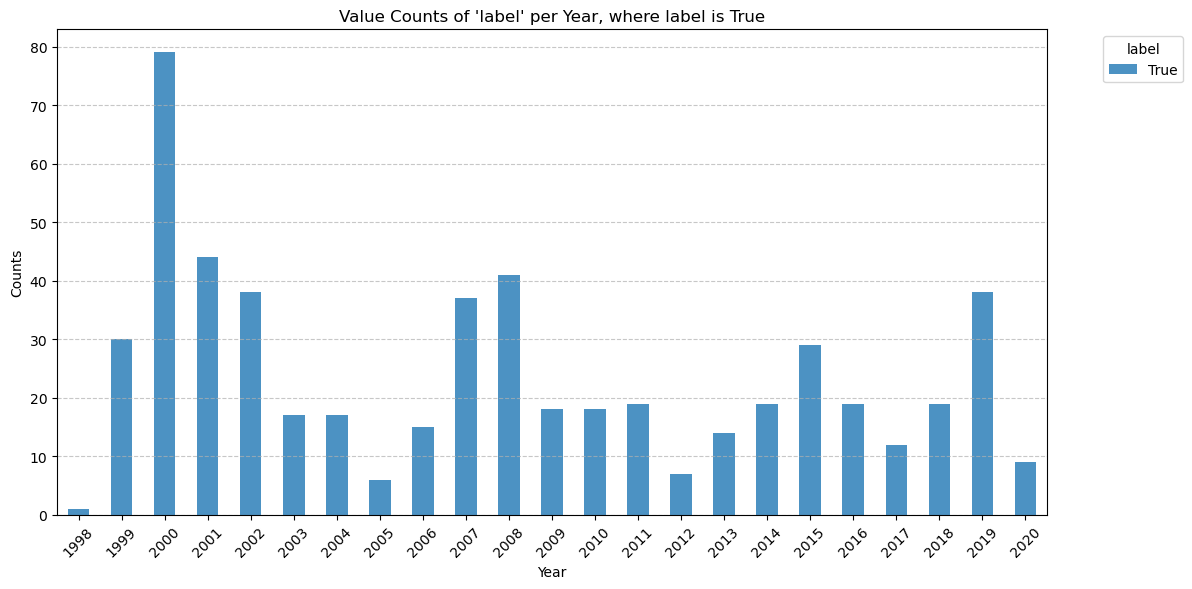

In [15]:
# Plot the distribution of the 'True' labels
true_labels_df =ecl_df[ecl_df['label' ]== True]
plot_value_counts_per_year(true_labels_df, year_column='cik_year', target_column='label')

# Year Distributions

### Plot the year distributions of the original ecl dataset, the added financial variables, and the final post_processed dataframe 

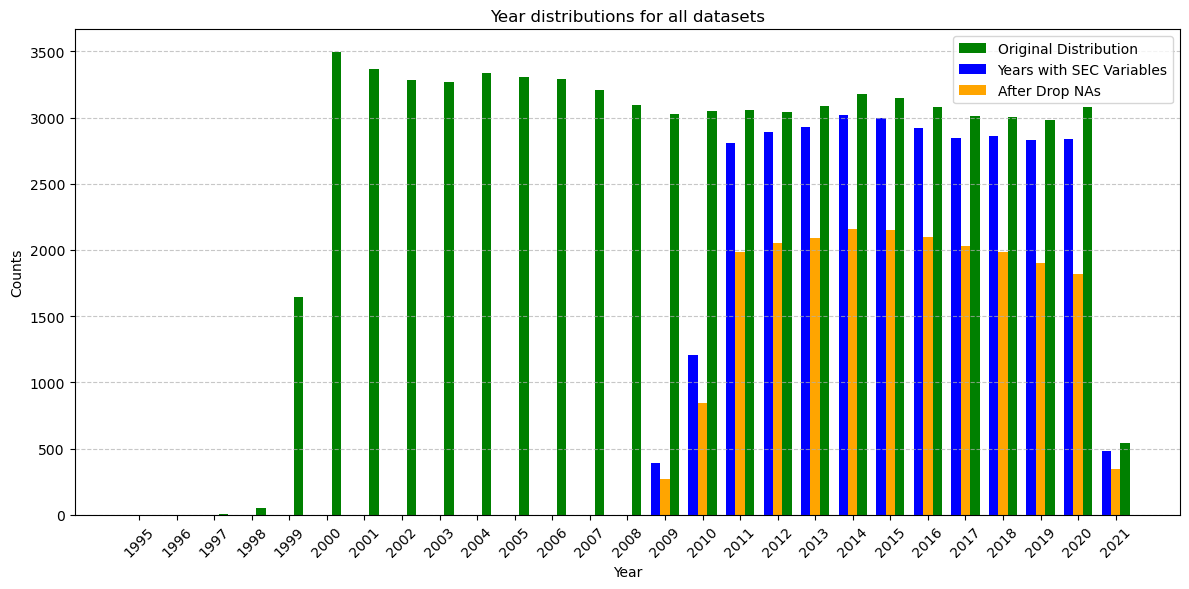

In [16]:
year_distribution_original = data_loader.column_distribution(key='ecl', column_name='cik_year')
year_distribution_before = data_loader.column_distribution(key='ecl_companyfacts', column_name='cik_year')
year_distribution_after = data_loader.column_distribution(key='ecl_companyfacts_processed', column_name='cik_year')

# Align all distributions to have the same years
all_years = (
    year_distribution_before.index
    .union(year_distribution_after.index)
    .union(year_distribution_original.index)
)

aligned_before = year_distribution_before.reindex(all_years, fill_value=0)
aligned_after = year_distribution_after.reindex(all_years, fill_value=0)
aligned_original = year_distribution_original.reindex(all_years, fill_value=0)

# Plot the distributions as overlaid bar graphs
plt.figure(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.25  # Reduced bar width to fit three bars
positions_before = np.arange(len(all_years))
positions_after = positions_before + bar_width
positions_original = positions_before + 2 * bar_width

# Plot the bars with transparency
plt.bar(positions_original, aligned_original.values, width=bar_width, label='Original Distribution', color='green')
plt.bar(positions_before, aligned_before.values, width=bar_width, label='Years with SEC Variables', color='blue')
plt.bar(positions_after, aligned_after.values, width=bar_width, label='After Drop NAs', color='orange')


# Adjust x-axis to show years properly
plt.xticks(positions_before + bar_width, all_years, rotation=45)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Year distributions for all datasets')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Bankruptcy Label Distributions

### Group each dataset by year and sum the counts of 'true' bankruptcy labels

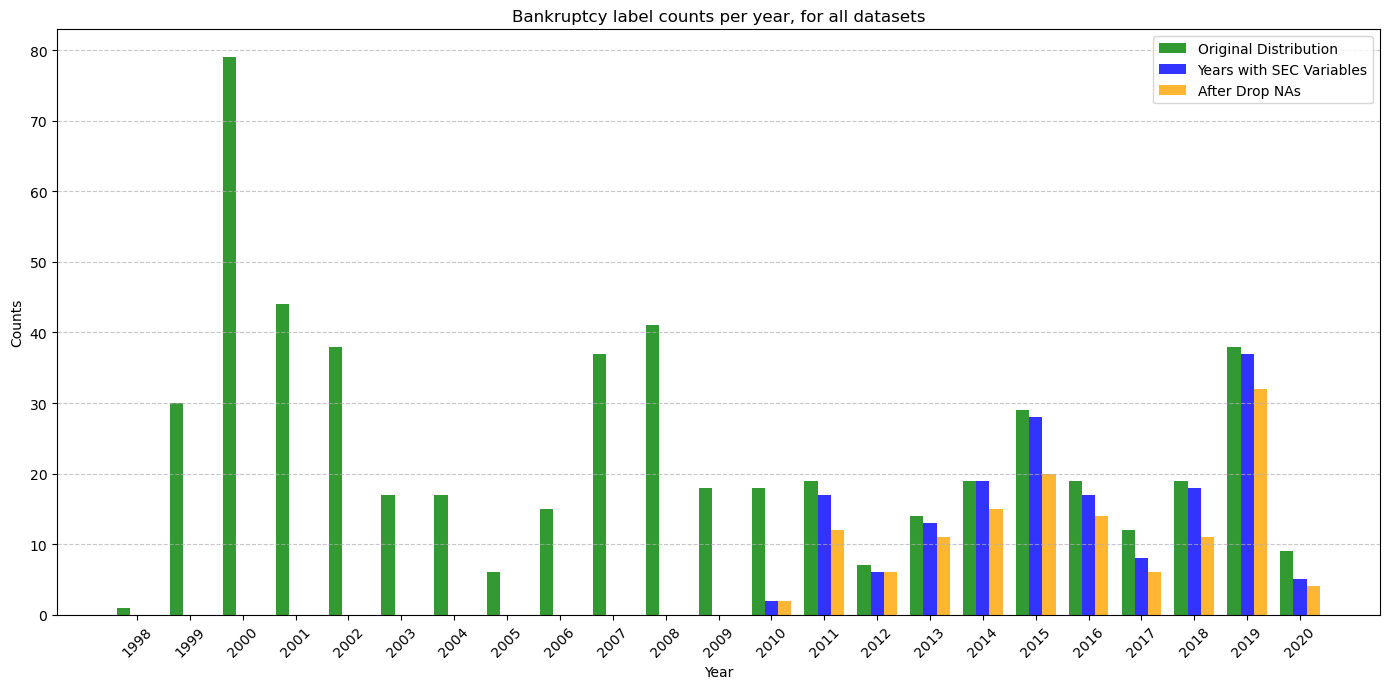

In [ ]:
year_distribution_before = ecl_companyfacts_df.groupby('cik_year')['label'].value_counts().rename("counts").reset_index()
year_distribution_before = year_distribution_before[year_distribution_before['label'] == True]

year_distribution_after = ecl_companyfacts_processed_df.groupby('cik_year')['label'].value_counts().rename("counts").reset_index()
year_distribution_after = year_distribution_after[year_distribution_after['label'] == True]

year_distribution_original = ecl_df.groupby('cik_year')['label'].value_counts().rename("counts").reset_index()
year_distribution_original = year_distribution_original[year_distribution_original['label'] == True]

def plot_year_distributions(df1, df2, df3, label1, label2, label3, year_column='cik_year', count_column='counts'):
    """
    Plots year distributions for three dataframes side by side for comparison.

    Parameters:
    - df1, df2, df3: The three dataframes to compare
    - label1, label2, label3: Labels for each dataframe in the legend
    - year_column: Column containing the years (default: 'cik_year')
    - count_column: Column containing the counts (default: 'counts')
    """
    # Align years across all dataframes
    all_years = pd.Series(
        sorted(
            set(df1[year_column]).union(set(df2[year_column])).union(set(df3[year_column]))
        )
    )

    # Fill missing years with 0 counts in all dataframes
    aligned_df1 = df1.set_index(year_column).reindex(all_years, fill_value=0).reset_index()
    aligned_df2 = df2.set_index(year_column).reindex(all_years, fill_value=0).reset_index()
    aligned_df3 = df3.set_index(year_column).reindex(all_years, fill_value=0).reset_index()

    # Ensure all columns are named consistently
    aligned_df1.columns = [year_column, 'label', count_column]
    aligned_df2.columns = [year_column, 'label', count_column]
    aligned_df3.columns = [year_column, 'label', count_column]

    # Extract years and counts
    years = aligned_df1[year_column]
    counts1 = aligned_df1[count_column]
    counts2 = aligned_df2[count_column]
    counts3 = aligned_df3[count_column]

    # Plot the bar chart
    bar_width = 0.25  # Adjust bar width to fit all three bars side by side
    x_positions = np.arange(len(years))  # X positions for the years

    plt.figure(figsize=(14, 7))

    # Plot the bars
    plt.bar(x_positions - bar_width, counts1, width=bar_width, label=label1, color='green', alpha=0.8)
    plt.bar(x_positions, counts2, width=bar_width, label=label2, color='blue', alpha=0.8)
    plt.bar(x_positions + bar_width, counts3, width=bar_width, label=label3, color='orange', alpha=0.8)
    plt.xticks(x_positions, years, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.title('Bankruptcy label counts per year, for all datasets')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming df1, df2, and df3 are the dataframes
plot_year_distributions(
    df1=year_distribution_original,
    df2=year_distribution_before,
    df3=year_distribution_after,
    label1='Original Distribution',
    label2='Years with SEC Variables',
    label3='After Drop NAs'
    # label2='Filtered Distribution 1',
    # label3='Filtered Distribution 2'
)

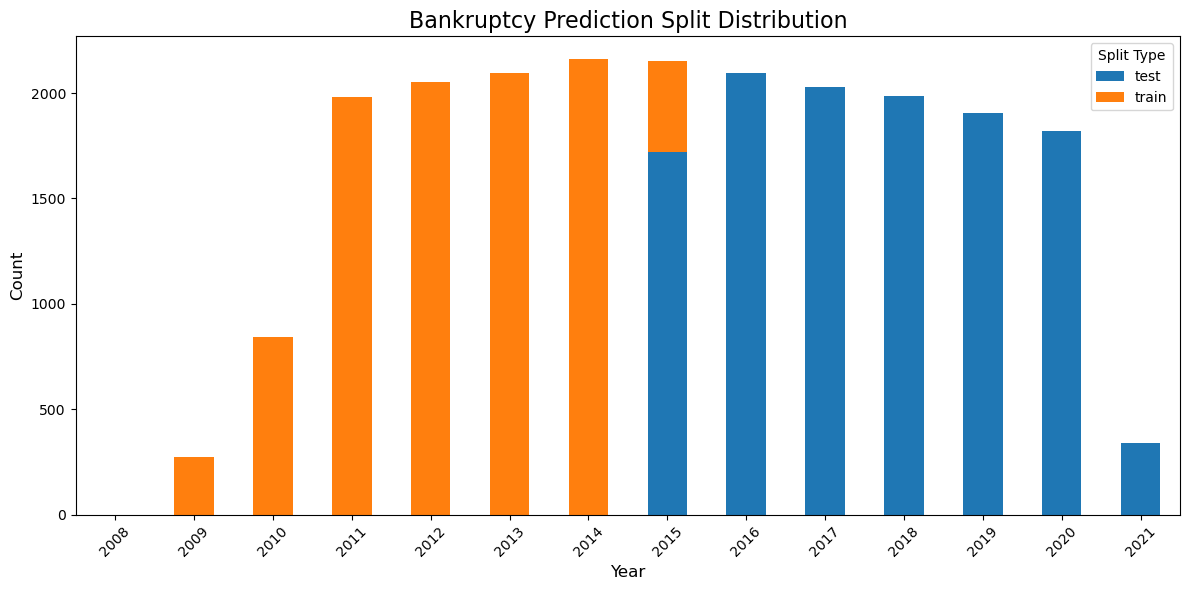

In [18]:
# Plot the distribution of 'bankruptcy_prediction_split'
result = ecl_companyfacts_processed_df.groupby(['cik_year', 'bankruptcy_prediction_split']).size().unstack(fill_value=0)
result.plot(kind='bar', figsize=(12, 6), stacked=True)

plt.title('Bankruptcy Prediction Split Distribution', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Split Type', fontsize=10)
plt.tight_layout()
plt.show()

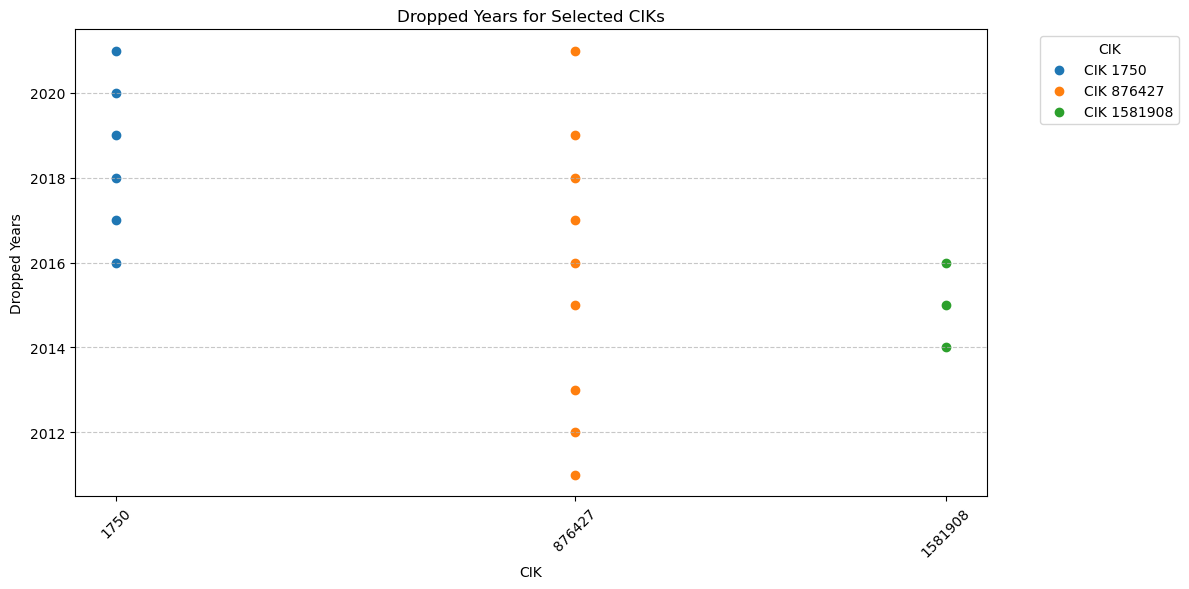

In [19]:
def find_and_visualize_dropped_years(full_df, smaller_df, cik_column='cik', year_column='year', selected_ciks=None, random_sample_size=5):
    """
    Find and visualize dropped years for each CIK, with options to filter or randomly sample CIKs.

    Parameters:
    - full_df: Full dataset
    - smaller_df: Smaller dataset with some rows dropped
    - cik_column: Column containing CIK identifiers
    - year_column: Column containing year values (in ecl: 'cik_year', but needs preprocessing)
    - selected_ciks: List of CIKs to plot (optional)
    - random_sample_size: Number of random CIKs to plot if no list is provided

    Returns:
    - A DataFrame showing missing years for each CIK
    """
    # Group years by CIK for both datasets
    full_years = full_df.groupby(cik_column)[year_column].apply(set)
    smaller_years = smaller_df.groupby(cik_column)[year_column].apply(set)
    

    # Find missing years for each CIK
    missing_years = full_years.subtract(smaller_years, fill_value=set())

    # Convert the result to a DataFrame
    missing_years_df = missing_years.reset_index(name='dropped_years')

    # Filter CIKs to plot
    if selected_ciks:
        filtered_missing = missing_years_df[missing_years_df[cik_column].isin(selected_ciks)]
    else:
        # Randomly sample CIKs if no list is provided
        all_ciks = missing_years_df[cik_column].unique()
        sampled_ciks = random.sample(list(all_ciks), min(random_sample_size, len(all_ciks)))
        filtered_missing = missing_years_df[missing_years_df[cik_column].isin(sampled_ciks)]

    # Visualize missing years
    plt.figure(figsize=(12, 6))
    for _, row in filtered_missing.iterrows():
        # Convert set of missing years to a sorted list for plotting
        missing_years_list = sorted(list(row['dropped_years']))
        plt.scatter([row[cik_column]] * len(missing_years_list), missing_years_list, label=f"CIK {row[cik_column]}")

    plt.xlabel('CIK')
    plt.ylabel('Dropped Years')
    plt.title('Dropped Years for Selected CIKs')
    plt.xticks(ticks=filtered_missing[cik_column], labels=filtered_missing[cik_column], rotation=45)    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='CIK', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return filtered_missing


# Use random sampling to plot 5 the missing years for 5 unique cik keys 
missing_years_df = find_and_visualize_dropped_years(
    ecl_companyfacts_df,
    ecl_companyfacts_processed_df,
    cik_column='cik',
    year_column='cik_year',
    # random_sample_size=5,
    selected_ciks=[1750, 1581908, 876427]
)


In [20]:

original_columns = get_column_list_from_json(config.ECL_FILE_PATH)
processed_columns = ecl_companyfacts_processed_df.columns
original_set = set(original_columns)
processed_set = set(processed_columns)

# Subtract original columns from processed columns
selected_variables = processed_set - original_set
selected_variables = list(selected_variables)
# print("Selected Financial Variables found in Processed File:", selected_variables)
# print(ecl_companyfacts_df[ecl_companyfacts_df['cik'] == 876427])


related_columns_result = analyze_missing_columns_by_cik(
    ecl_companyfacts_df=ecl_companyfacts_df,
    cik=1581908,
    years=[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021],
    columns_to_check=selected_variables
)


Analyzing company "WESTERN REFINING LOGISTICS, LP", with CIK = 1581908.
--- Analyzing Year: 2012 ---
No variables were matched for this year.
--- Analyzing Year: 2013 ---
No variables were matched for this year.
--- Analyzing Year: 2014 ---
No related variables found for missing column "EntityCommonStockSharesOutstanding".
No related variables found for missing column "RetainedEarningsAccumulatedDeficit".
Missing Column: StockholdersEquity
Related Columns: ['LiabilitiesAndStockholdersEquity', 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest']
Values in Related Columns:
{'LiabilitiesAndStockholdersEquity': 307043000.0, 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest': 293987000.0}


--- Analyzing Year: 2015 ---
No related variables found for missing column "EntityCommonStockSharesOutstanding".
No related variables found for missing column "RetainedEarningsAccumulatedDeficit".
Missing Column: StockholdersEquity
Related Columns: ['Liabilities